# Evaluation: *benchmark* data experiments

Here we process the results of the benchmark data experiments following Ishida et al. (2020), also using [some handy coding examples](https://gist.github.com/DavidWalz/0f5e84ffc4c3929f3af5a93268eaeab9).

In [1]:
# External modules.
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os

# Internal modules.
from setup.directories import img_path
from setup.results import my_ext
from setup.utils import makedir_safe

In [2]:
# Make a directory to store images, if one doesn't exist already.
makedir_safe(img_path)

In [3]:
# Specify an experiment name, get relevant information.
exp_name = "exp:svhn"
data_name = exp_name.split(":")[1]
experiment = mlflow.get_experiment_by_name(name=exp_name)
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))
exp_id = experiment.experiment_id

Experiment_id: 729107857486726074
Artifact Location: file:///home/mjh/exps_bdd-flood/2023-09-26/bdd-flood-dev/bdd-flood/mlruns/729107857486726074
Tags: {}
Lifecycle_stage: active
Creation timestamp: 1695771915373


As we will see below, the object returned by `mlflow.search_runs(exp_id)` is an instance of a `DataFrame` within the "pandas" library. The `DataFrame` is just a simple class for managing "tabular" data, i.e., data organized into rows and columns. A two-dimensional array. Let's take a look at the points characterizing this particular data frame.

In [4]:
# Take a look at the "runs" associated with the selected experiment.
runs = mlflow.search_runs(exp_id)
runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   run_id                          3 non-null      object             
 1   experiment_id                   3 non-null      object             
 2   status                          3 non-null      object             
 3   artifact_uri                    3 non-null      object             
 4   start_time                      3 non-null      datetime64[ns, UTC]
 5   end_time                        3 non-null      datetime64[ns, UTC]
 6   metrics.model_norm              2 non-null      float64            
 7   metrics.loss_va                 2 non-null      float64            
 8   metrics.acc_te                  2 non-null      float64            
 9   metrics.acc_va                  2 non-null      float64            
 10  metrics.acc_tr    

Okay, so we have 46 columns, each with one or more "entries" that we can interpret as rows. Each "entry" is associated with a single "run" (in mlflow terms). It should also be noted that the "Non-Null Count" (i.e., the number of non-null entries) differs between columns. Here, the null entries are associated with the "parent runs" (just one parent run here, capturing all other runs). There are no entries for these runs because no metrics are assigned to the parent runs, only their children.

Anyways, moving forward, we want to extract runs as follows.

- For each *trial* and each *method*, using validation data to choose the best method setting (assuming there are multiple settings).
- Finally, we want to compute statistics for the selected methods (ave, stdev, etc.) taken over all trials.

Let's set up a script to do this, making sure to do a few relevant sanity checks along the way.

In [5]:
# Look at all runs with a non-null setting (basically any param is fine).
runs_notnull = runs[runs["params.bs_tr"].notnull()]
runs_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 0 to 1
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   run_id                          2 non-null      object             
 1   experiment_id                   2 non-null      object             
 2   status                          2 non-null      object             
 3   artifact_uri                    2 non-null      object             
 4   start_time                      2 non-null      datetime64[ns, UTC]
 5   end_time                        2 non-null      datetime64[ns, UTC]
 6   metrics.model_norm              2 non-null      float64            
 7   metrics.loss_va                 2 non-null      float64            
 8   metrics.acc_te                  2 non-null      float64            
 9   metrics.acc_va                  2 non-null      float64            
 10  metrics.acc_tr         

Excellent. Note that having removed the rows/runs with null values for `params.bs_tr`, all the other columns are also now null-free, as expected. That was easy.

Moving forward, we would like to parse the `tags.mlflow.runName` column, splitting it into several columns that makes it much easier to index things.

In [6]:
# First, let's make a copy of the whole data frame to be safe.
runs_notnull_parsed = runs_notnull.copy()

# Next, grab the column to be parsed, populate some lists, turn into Series objects.
mth_family_names = []
mth_numbers = []
trial_numbers = []
for run_name in runs_notnull_parsed["tags.mlflow.runName"]:
    pc_check, mth_details = run_name.split(":")
    if pc_check == "parent":
        raise ValueError("Something is wrong; should not have any parent runs here.")
    elif pc_check == "child":
        mth_family_name, mth_number, trial_info = mth_details.split("-")
        mth_family_names += [mth_family_name]
        mth_numbers += [int(mth_number)]
        trial_numbers += [int(trial_info[1:])]
    else:
        raise ValueError("Something is wrong; did not find a child run.")

# Try adding these columns to the right-most side of the DataFrame of interest.
original_width = runs_notnull_parsed.shape[1]
runs_notnull_parsed.insert(original_width, "trial_number", trial_numbers)
runs_notnull_parsed.insert(original_width, "mth_number", mth_numbers)
runs_notnull_parsed.insert(original_width, "mth_family", mth_family_names)
runs_notnull_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 0 to 1
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   run_id                          2 non-null      object             
 1   experiment_id                   2 non-null      object             
 2   status                          2 non-null      object             
 3   artifact_uri                    2 non-null      object             
 4   start_time                      2 non-null      datetime64[ns, UTC]
 5   end_time                        2 non-null      datetime64[ns, UTC]
 6   metrics.model_norm              2 non-null      float64            
 7   metrics.loss_va                 2 non-null      float64            
 8   metrics.acc_te                  2 non-null      float64            
 9   metrics.acc_va                  2 non-null      float64            
 10  metrics.acc_tr         

Good, that was extremely easy. Before getting into some proper analysis, let's do some basic sanity checks.

In [7]:
# Check family names.
runs_tocheck = runs_notnull_parsed
unique_trial_numbers = np.sort(runs_notnull_parsed["trial_number"].unique())
print("- - Unique trial numbers:", unique_trial_numbers)
unique_family_names = np.sort(runs_notnull_parsed["mth_family"].unique())
print("- - Unique family names:", unique_family_names)
# Check method numbers.
for mth_family_name in unique_family_names:
    idx_methods = runs_tocheck["mth_family"] == mth_family_name
    runs_tocheck_methods = runs_tocheck[idx_methods]
    print("- - - Method number counts ({}):".format(mth_family_name))
    print(runs_tocheck_methods["mth_number"].value_counts())

- - Unique trial numbers: [0 1]
- - Unique family names: ['ERM']
- - - Method number counts (ERM):
mth_number
0    2
Name: count, dtype: int64


Excellent, the sanity checks come out with the results that we expect. We are going to have need for metrics soon, so let's be sure to grab the metric names now.

In [8]:
# Metric names.
metrics = [c[8:] for c in runs_notnull_parsed.columns if c.startswith("metrics")]

# Specify the metric to be used for validation.
metric_for_validation = "acc_va"
if metric_for_validation not in metrics:
    raise ValueError("The selected metric {} is not available...".format(metric_for_validation))
print("All metric names:", metrics)
if metric_for_validation == "loss_va":
    do_argmax = False
elif metric_for_validation == "acc_va":
    do_argmax = True
else:
    raise ValueError("Unexpected metric for validation.")

# Function in charge of selecting the best candidate.
def get_best_idx(metric_history_list, do_argmax=do_argmax):
    '''
    Given a list of sequences, this function returns the index
    of the "best" sequence by taking an *argmax/min* over the *final* values
    of these sequences (e.g., final accuracy, loss, etc.).
    '''
    list_len = len(metric_history_list)
    if list_len < 1:
        raise ValueError("No metric histories provided.")
    elif list_len == 1:
        return 0
    else:
        values_to_compare = []
        for mh in metric_history_list:
            values_to_compare += [mh[-1]] # use last step.
        if do_argmax:
            return np.argmax(np.array(values_to_compare)).item()
        else:
            return np.argmin(np.array(values_to_compare)).item()


All metric names: ['model_norm', 'loss_va', 'acc_te', 'acc_va', 'acc_tr', 'loss_te', 'loss_tr']


To proceed, we set up a loop very similar to the one we just did for our sanity checks, but this time we grab *candidate run IDs*, use these to read in the *metric history*, and then finally choose a *representative run ID* for each combination of (trial, method family).

In [9]:
# Set up a dictionary where we can store "representative" run IDs and results for each method family.
dict_of_run_ids = {m:[] for m in unique_family_names}

# Get the loop going, with a "client" for reading in metric history.
client = mlflow.tracking.MlflowClient()
runs_tocheck = runs_notnull_parsed
unique_trial_numbers = np.sort(runs_notnull_parsed["trial_number"].unique())
unique_family_names = np.sort(runs_notnull_parsed["mth_family"].unique())
for trial_number in unique_trial_numbers:
    runs_tocheck_bytrial = runs_tocheck[runs_tocheck["trial_number"] == trial_number]
    for mth_family_name in unique_family_names:
        idx_candidates = runs_tocheck_bytrial["mth_family"] == mth_family_name
        runs_tocheck_byfamily = runs_tocheck_bytrial[idx_candidates]
        candidate_run_ids = runs_tocheck_byfamily.run_id
        #print(type(candidate_run_ids), len(candidate_run_ids))
        #print(candidate_run_ids)
        if len(candidate_run_ids) == 1:
            # If only one setting, no need to check validation data.
            best_idx = 0
        elif len(candidate_run_ids) > 1:
            # When have multiple settings, use the specified metric for validation.
            metric_history_list = [
                [s.value for s in client.get_metric_history(r, metric_for_validation)] for r in candidate_run_ids
            ]
            best_idx = get_best_idx(metric_history_list)
        else:
            raise ValueError("No candidate runs...!")
            
        dict_of_run_ids[mth_family_name] += [candidate_run_ids.iloc[best_idx]]
                
print(dict_of_run_ids)

{'ERM': ['66078c307a6d46398e10e34e4db1488b', 'fc90164b001647679f24bca173ddbb7c']}


With all the final candidate run IDs in place, all that remains is to get the relevant metric histories for each, and plot them in a clear, readable fashion.

final values (ave, loss_tr)
  0.0010745938925538212 (ERM)
final values (ave, loss_te)
  0.6929745674133301 (ERM)
final values (ave, acc_tr)
  0.999863475561142 (ERM)
final values (ave, acc_te)
  0.9059618711471558 (ERM)
final values (ave, model_norm)
  277.10743713378906 (ERM)


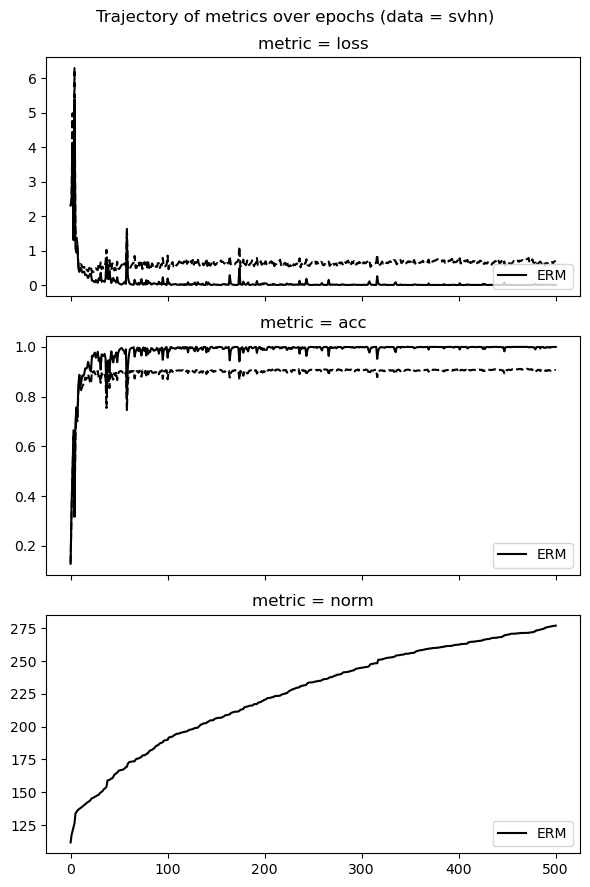

In [10]:
# List of metrics to use for each subplot.
metrics_to_use_list = [["loss_tr", "loss_te"], ["acc_tr", "acc_te"], ["model_norm"]]

# Color setup.
colors_by_method = {
    "ERM": "xkcd:black",
    "Ishida": "xkcd:aquamarine",
    "SAM": "xkcd:neon purple",
    "SoftAD": "xkcd:pinkish red"
}

# Name setup.
plotnames_by_method = {
    "ERM": "ERM",
    "Ishida": "Flood",
    "SAM": "SAM",
    "SoftAD": "SoftAD"
}

# Extra details to check.
extras_by_method = {
    "ERM": [],
    "Ishida": ["params.flood_level"],
    "SAM": ["params.radius"],
    "SoftAD": ["params.theta"],
}


client = mlflow.tracking.MlflowClient()
# Prepare the figure (one sub-plot per metric, but with tr and te on same plot).
fig, axes = plt.subplots(3, figsize=(6, 3*len(metrics_to_use_list)), sharex=True)

# Get the run IDs selected for all methods.
best_run_ids = dict_of_run_ids

# For each method, look at extra info of interest.
for mth_family_name in best_run_ids:
    extras_list = extras_by_method[mth_family_name]
    if len(extras_list) > 0:
        df = runs_notnull_parsed[runs_notnull_parsed["run_id"].isin(best_run_ids[mth_family_name])]
        for extra_name in extras_list:
            print("({}, {})".format(mth_family_name, extra_name))
            print("mean:", df[extra_name].astype(float).mean(),
                  "stdev:", df[extra_name].astype(float).std())
            print(df[extra_name])

# Get a loop going.
for ax, metrics_to_use in zip(axes, metrics_to_use_list):

    # Process things for the first metric (always at least one).
    metric_to_use = metrics_to_use[0] # set metric name by hand.
    print("final values (ave, {})".format(metric_to_use))
    for mth_family_name in best_run_ids:
        # Get metrics for the representative candidates.
        metric_array = [
            [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
        ]
        # Organize into a numpy array, and plot the average over trials.
        metric_array = np.array(metric_array)
        #print("DBDB", mth_family_name, metric_to_use, metric_array.shape)
        ax.plot(
            np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
            color=colors_by_method[mth_family_name],
            linestyle="solid",
            label=plotnames_by_method[mth_family_name]
        )
        print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))

    # If have more than one metric, plot the second one, but no more.
    if len(metrics_to_use) > 1:
        metric_to_use = metrics_to_use[1] # set metric name by hand.
        print("final values (ave, {})".format(metric_to_use))
        for mth_family_name in best_run_ids:
            # Get metrics for the representative candidates.
            metric_array = [
                [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
            ]
            # Organize into a numpy array, and plot the average over trials.
            metric_array = np.array(metric_array)
            ax.plot(
                np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
                color=colors_by_method[mth_family_name],
                linestyle="dashed"
            )
            print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))
    if len(metrics_to_use) > 2:
        raise ValueError("Expected one or two metrics, no more/less.")

    # Having plotted for all methods, configure other parts of the current sub-plot.
    metric_name_for_plot = metrics_to_use[0].split("_")[0 if len(metrics_to_use) > 1 else 1]
    ax.set_title("metric = {}".format(metric_name_for_plot))
    ax.legend(loc="best")
    
# Finally, macroscropic settings for the whole figure.
fig.suptitle(
    "Trajectory of metrics over epochs (data = {})".format(data_name)
)
plt.tight_layout()
fname = os.path.join(img_path, "benchmarks_{}.{}".format(data_name, my_ext))
plt.savefig(fname=fname)
plt.show()

___